# Radial Distortion Estimation :-

## Libraries needed:-

In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pandas as pd
from scipy import linalg
from scipy.optimize import minimize

%matplotlib inline
np.set_printoptions(suppress=True)

## Reading World and Image coordinates :-

In [2]:
def read_coordinates():
    data = pd.read_excel("Coordinates.xlsx")
    #data = pd.read_excel("3D/dataset.xlsx")
    display(data)
    
    #WORLD COORDINATES
    X = np.array(data['X'])
    Y = np.array(data['Y'])
    Z = np.array(data['Z'])
    
    #IMAGE PIXEL COORDINATES
    x = np.array(data['x'])
    y = np.array(data['y'])
    
    # LIST OF WORLD PTS AND CORRESPONDING PIXEL PTS
    world_pts = []
    pixel_pts = []
    
    for i in range(len(X)):
        world_pts.append([X[i], Y[i], Z[i]])
        pixel_pts.append([x[i], y[i]])

    return world_pts, pixel_pts

##  Isotropic point normalization of Input Coordinates:-

In [3]:
def Normalize(data):
    """
    Isotropic point normalization
    
    Returns:
    Homgenous coordinates, Transformation matrix
    """
    num_pts = len(data)
    dim = len(data[0])
    data = np.asarray(data)
    
    #Find mean/centroid of the data and normalize avergae distance
    mu = np.mean(data, axis=0)
    avg_dist = np.mean(np.sqrt(np.sum(np.square(data - mu))))
    scale = np.sqrt(dim)/avg_dist
    
    T = np.zeros([dim, dim])
    if dim == 2:
        T = np.diag([scale, scale, 1])
        T[0,2] = -scale*mu[0]
        T[1,2] = -scale*mu[1]
    elif dim == 3:
        T = np.diag([scale, scale, scale, 1])
        T[0,3] = -scale*mu[0]
        T[1,3] = -scale*mu[1]
        T[2,3] = -scale*mu[2]
    
    #Homogeneous coordinate
    col = np.ones([num_pts, 1])
    tr_data = np.append(data, col, axis=1)
    
    #After scaling
    tr_data = np.matmul(T, tr_data.T).T #This might be wrong
    tr_data = tr_data[:,0:dim]
    
    # Return transformed data and transformation matrix
    # print("Transformation matrix to normalize data: \n", T)
    # print("\n")
    return tr_data, T
    

## Function to Estimate (3x4) Projection Matrix:-

In [4]:
def CalibrateDLT(world_pts, pxl_pts):
    """
    Estimates  the  3  ×  4  projection  matrix  P  
    and  then  decompose  it  into  theintrinsics and extrinsics. 
    """
    num_pts = len(world_pts)
    
    world_pts = np.asarray(world_pts)
    pxl_pts = np.asarray(pxl_pts)
    
    world_pts_normalized, T_world = Normalize(world_pts)
    pxl_pts_normalized, T_pxl = Normalize(pxl_pts)
    
    #First, Find projection matrix
    A = []
    
    for i in range(num_pts):
        X, Y, Z = world_pts_normalized[i, 0], world_pts_normalized[i, 1], world_pts_normalized[i, 2]
        x, y = pxl_pts_normalized[i, 0], pxl_pts_normalized[i, 1]
        r1 = [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x]
        r2 = [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]
        
        A.append(r1)
        A.append(r2)
    
    # Convert A to array
    A = np.asarray(A) 
    
    # Am = 0
    # Perform SVD to find the eigenvector with smallest eigen value,
    # where 'm' is right singular vector of A i.e. V corresponding to singular value zero
    # U: Left singular vector
    # S: Singular values (equivalent to eigenvalue)
    # V: Right singular vector
    #
    # There are total 4 zero singular values. Try vector corresponding to all 4
    U, S, V = np.linalg.svd(A)
    
    #Camera Projection matrix
    #Choose the one which gives smallest error
    H = V[-1,:]#/V[-1, -1] 
    H = H.reshape(3, 4)
    
    print("Camera Projection Matrix: \n")
    print(H)
    print("\n")
    
    #Denormalize
    #https://web.archive.org/web/20150929063658/http://www.ele.puc-rio.br/~visao/Topicos/Homographies.pdf
    #H = inv(T_pixel)*H'*T_world
    H = np.matmul( np.matmul( np.linalg.pinv(T_pxl), H ), T_world )
    #H = H/H[-1, -1]
    
    print("Camera Projection Matrix (after denormalization): \n")
    print(H)
    
    # Mean error of the DLT (mean residual of the DLT transformation in units of camera coordinates):
    estimated_pt = np.dot( H, np.concatenate( (world_pts.T, np.ones((1, world_pts.shape[0]))) ) ) 
    estimated_pt = estimated_pt / estimated_pt[2, :] 
    estimated_pt = np.asarray(estimated_pt.T)
    
    err = np.sqrt( np.mean(np.sum( (estimated_pt[:,0:2] - pxl_pts)**2, 1)) ) 
    print("\nError: ", err)
    
    #Plot points
    f = plt.figure()
    plt.scatter(pxl_pts[:,0], pxl_pts[:,1], label="Pixel points")
    plt.scatter(estimated_pt[:,0], estimated_pt[:,1], color='red', label='Estimated points')
    plt.legend()
    plt.show()
    
    return H, err, estimated_pt

## Extracting Intrinsic and Extrinsic Parameters from Projection Matrix:-

In [5]:
def Do_RQ_decomposition(H, pxl_pts):
    """
    Input: Camera projection matrix
    Outout: Intrinsic and extrinsic parameter
    """
    
    #Estimation by formoulas given in Forsyth
    KR = H[0:3, 0:3]
    rho = 1/np.linalg.norm(KR[2,:])
    xo = (rho**2)*np.sum(np.dot(KR[0,:], KR[2,:]))
    yo = (rho**2)*np.sum(np.dot(KR[1,:], KR[2,:]))
    
    t1 = np.cross(KR[0,:], KR[2,:])
    t2 = np.cross(KR[1,:], KR[2,:])
    theta = -np.dot(t1, t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
    theta = np.arccos(theta)
    
    alpha = (rho**2)*np.linalg.norm(t1)*np.sin(theta)
    beta = (rho**2)*np.linalg.norm(t2)*np.sin(theta)
    
    #Find K (Calibration matrix - intrinsic) and R (Rotation matrix)
    #Details of the procedure: https://drive.google.com/file/d/1CdTH1v94yW28LfozrfOCc3it-KH8OrSS/view?usp=sharing
    #Q = Orthogonal matrix (Rotation matrix, Extrinsic parameter), 
    #R = Upper triangular matrix (Camera Calibration matrix, Intrinsic parameter)
    # Very important to get correct camera center: Should be RQ decomposition
    R, Q = linalg.rq(H[0:3, 0:3]) #Consider decomposition of 3x3 matrix only. 
    Rot_Mat = Q
    K = R
    #K = K/K[-1,-1] #This gives incorrect camera center
    print("\n Rotation Matrix: \n", Rot_Mat)
    print("\n Camera calibration matrix: \n", K/K[-1,-1])
    
    #Find t (translation matrix, extrinsic matrix) from known K
    t = np.matmul(np.linalg.inv(K), H[:,3])
    print("\n Translation matrix: \n", t)
    
    #Camera center in world coordinate system
    CW = -np.matmul(np.linalg.inv(Rot_Mat), t.reshape(3,1))
    print("\n Camera center: \n", CW)
    
    K = K/K[-1,-1] #Do this after center has been calculated
    #Principal point
    Prncpl_pt = K[0:2,2]
    print("\n Principal point (in pixels): \n", Prncpl_pt)
    
    #Skewness
    THETA = np.arctan(-K[0,0]/K[0,1])*180/np.pi
    print("\n Skewness (θ): \n", np.abs(90 - THETA))
    
    #Alpha and Beta
    print("\n Alpha (fx in pixel): \n", np.absolute(K[0,0]))
    print("\n Beta (fy in pixel): \n", np.absolute( K[1,1]/np.sin(np.deg2rad(THETA)) ) )
    
    focal_length = np.asarray([alpha, beta])
    return focal_length, Rot_Mat, t, Prncpl_pt

## Radial Distortion using Levenberg-Marquardt algorithm:-

In [6]:
radial_distortion_vals = []

def radial_distortion(params, world_points, image_points, focal_length, Rot_Mat, T, Prncpl_pt):
    k1, k2 = params
    c = Prncpl_pt 
    f = focal_length 
    R = Rot_Mat 
    t = T 
    
    # Project the world points into the image plane
    projected_points = np.zeros_like(image_points)
    for i, world_point in enumerate(world_points):
        x, y, z = world_point
        #In CCS
        X, Y, Z = np.dot(R, world_point) + t
        #Find distorted point on image plane
        x_p = f[0] * X / Z + c[0]
        y_p = f[1] * Y / Z + c[1]
        
        #Initially k1 and k2 is zero but as it is updted the error reduces
        r_2 = x_p**2 + y_p**2
        x_d = x_p * (1 + k1 * r_2 + k2 * r_2**2)
        y_d = y_p * (1 + k1 * r_2 + k2 * r_2**2)
        
        projected_points[i, :] = x_d, y_d
    
    # Compute the radial distortion
    radial_distortion = np.sum((projected_points - image_points)**2)
    
    radial_distortion_vals.append(radial_distortion)
    
    return radial_distortion

def correct_radial_distortion(image_points, k1, k2):
    # Correct the radial distortion in the image points
    corrected_image_points = np.zeros_like(image_points)
    for i, image_point in enumerate(image_points):
        x_p, y_p = image_point
        r_2 = x_p**2 + y_p**2
        x_d = x_p * (1 + k1 * r_2 + k2 * r_2**2)
        y_d = y_p * (1 + k1 * r_2 + k2 * r_2**2)
        corrected_image_points[i, :] = x_d, y_d
    
    return corrected_image_points

,X,Y,Z,x,y
0,10.2,0.0,24.0,966,609
1,3.4,0.0,20.6,1402,812
2,13.6,0.0,13.8,795,1493
3,0.0,0.0,13.8,1575,1238
4,6.8,0.0,10.4,1277,1578
5,10.2,0.0,3.6,1066,2057
6,0.0,6.8,24.0,1969,585
7,0.0,13.6,20.6,2395,1006
8,0.0,10.2,13.8,2092,1462
9,0.0,6.8,7.0,1869,1800


Camera Projection Matrix: 

[[ 0.37715351 -0.3343705  -0.00645516  0.00410512]
 [-0.12963786 -0.15418492  0.49641388 -0.01360073]
 [ 0.18075748  0.19575325  0.13359992 -0.60816186]]


Camera Projection Matrix (after denormalization): 

[[ 0.37715351 -0.3343705  -0.00645516  0.00410512]
 [-0.12963786 -0.15418492  0.49641388 -0.01360073]
 [ 0.18075748  0.19575325  0.13359992 -0.60816186]]

Error:  0.008719119093885001


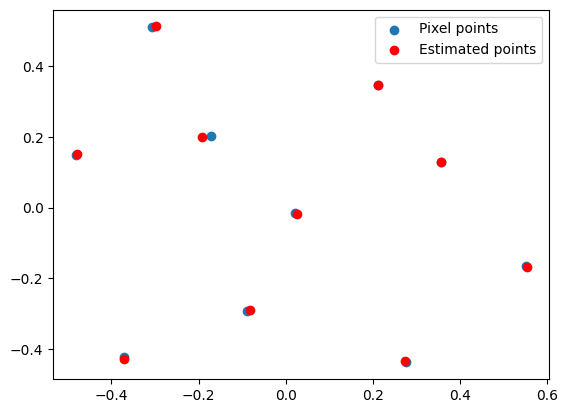


 Rotation Matrix: 
 [[ 0.73990212 -0.67253219 -0.01566232]
 [-0.29116093 -0.34114248  0.89378248]
 [-0.60644057 -0.6567513  -0.44822714]]

 Camera calibration matrix: 
 [[-1.69102757  0.0050791   0.02090011]
 [-0.         -1.79167014  0.14301463]
 [-0.         -0.          1.        ]]

 Translation matrix: 
 [0.03377515 0.1373991  2.04038042]

 Camera center: 
 [[1.25238441]
 [1.40961003]
 [0.79227797]]

 Principal point (in pixels): 
 [0.02090011 0.14301463]

 Skewness (θ): 
 0.17209075222321246

 Alpha (fx in pixel): 
 1.6910275716134375

 Beta (fy in pixel): 
 1.7916782261988131

Radial distortion coefficients: k1 = -8.7503, k2 = 9.6563
(10, 2) (10, 2)


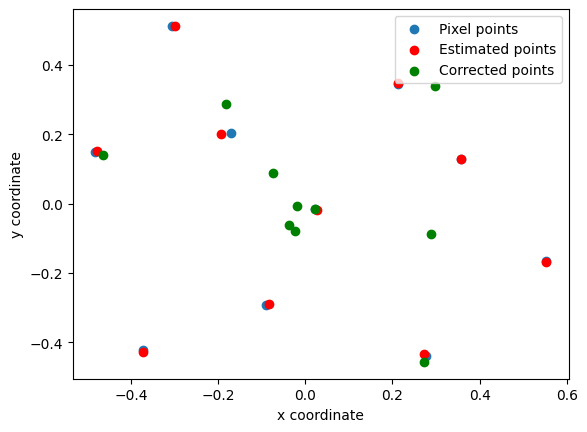

In [7]:
world_pts, pxl_pts = read_coordinates()

#Normalize before performing DLT to avoid numerical issues while calculating radial distortion
world_pts_normalized, T_world = Normalize(world_pts)
pxl_pts_normalized, T_pxl = Normalize(pxl_pts)
world_pts, pxl_pts = world_pts_normalized, pxl_pts_normalized

H, err, estimated_pt = CalibrateDLT(world_pts, pxl_pts)
focal_length, Rot_Mat, t, Prncpl_pt = Do_RQ_decomposition(H, pxl_pts)

"""
Find radial distortion
Normaize point before finding radial distortion to avoid numerical issues
"""
# Initial guess for the radial distortion coefficients
x0 = [0, 0]

# Minimize the radial distortion using the Levenberg-Marquardt algorithm
world_pts_normalized, T_world = Normalize(world_pts)
pxl_pts_normalized, T_pxl = Normalize(pxl_pts)
result = minimize(radial_distortion, x0, args=(world_pts, pxl_pts, focal_length, Rot_Mat, t, Prncpl_pt), method='L-BFGS-B')

# Extract the radial distortion coefficients
k1, k2 = result.x
print("\nRadial distortion coefficients: k1 = {:.4f}, k2 = {:.4f}".format(k1, k2))

#Correct estimated point after finding radial distortion coefficient
corrected_image_points = correct_radial_distortion(pxl_pts, k1, k2)
print(pxl_pts.shape, corrected_image_points.shape)

f = plt.figure()
plt.scatter(pxl_pts[:,0], pxl_pts[:,1], label="Pixel points")
plt.scatter(estimated_pt[:,0], estimated_pt[:,1], color='red', label='Estimated points')
plt.scatter(corrected_image_points[:,0], corrected_image_points[:,1], color='green', label='Corrected points')
plt.legend()
plt.grid
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.show()

## RMSE error from LM-Optimization-algorithm:-

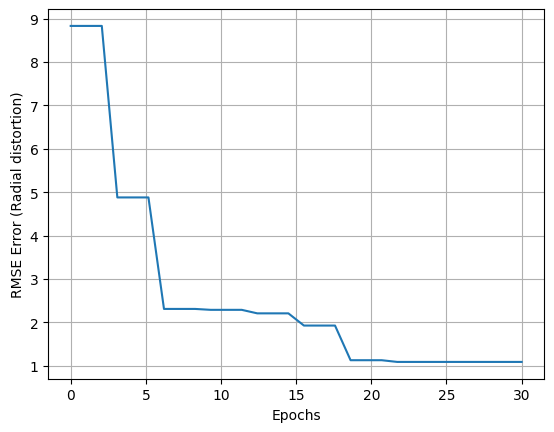

In [8]:
f = plt.figure()
plt.plot(np.linspace(0, len(radial_distortion_vals), len(radial_distortion_vals)), radial_distortion_vals)
plt.xlabel("Epochs")
plt.ylabel("RMSE Error (Radial distortion)")
plt.grid()
plt.show()